# Задание 3. Выделение границ/сегментация, преобразование Хафа/текстурный анализ (Вариант 2)

### 1. Алгоритм выделения границ Канни

**1) Импортируем окружение**

In [1]:
import cv2
import statistics as st
import math
import time
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import random
from collections import deque
import sys
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
print(cv2.__version__)

4.4.0


**2) Импортируем изображение**

In [2]:
image = cv2.imread("img1.jpg")

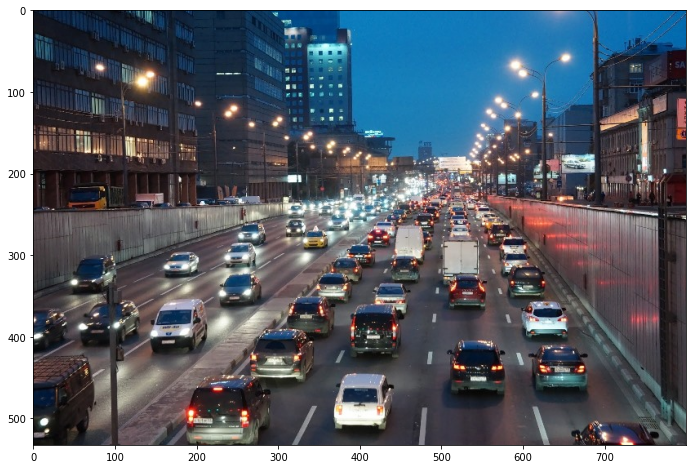

In [3]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

**3) Переводим изображение в монохром**

In [4]:
def to_gray(image):
    image2 = np.empty([image.shape[0], image.shape[1]])
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            pixel = image[i, j]
            average = int(pixel[0]) * 0.114 + int(pixel[1]) * 0.587 + int(pixel[2]) * 0.229
            image2[i, j] = average
    return image2

In [5]:
image2 = to_gray(image)

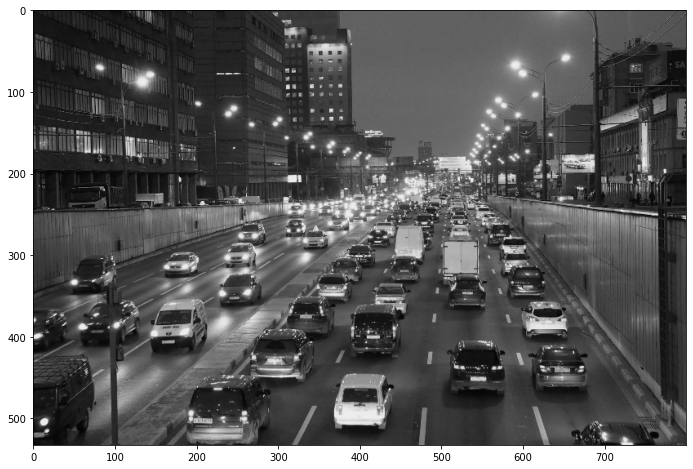

In [6]:
plt.figure(figsize=(12, 8))
plt.imshow(image2, cmap='gray', vmin = 0, vmax = 255)

**4) Размываем гаусом**

In [7]:
def convolution(img, kernel):
    image_h = img.shape[0]
    image_w = img.shape[1]    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    image_pad = np.pad(img, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0] - h):
        for j in range(w, image_pad.shape[1] - w):
            x = image_pad[i - h : i - h + kernel_h, j - w : j - w + kernel_w]
            x = x.flatten() * kernel.flatten()
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h :, w : w_end]
    if(w == 0):
        return image_conv[h : h_end, w:]
    return image_conv[h : h_end, w:w_end]

def gaussian_filter(img, sigma):
    kernel_size = 2 * int(4 * sigma + 0.5) + 1
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    m = kernel_size // 2
    n = kernel_size // 2
    
    for x in range(-m, m + 1):
        for y in range(-n, n + 1):
            x1 = 2 * np.pi * (sigma ** 2)
            x2 = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            kernel[x + m, y + n] = (1 / x1) * x2
    
    img_filtered = np.zeros_like(img, dtype = np.float32)
    img_filtered[:, :] = convolution(img[:, :], kernel)
    return (img_filtered.astype(np.uint8))

In [8]:
image3 = gaussian_filter(image2, 0.8)

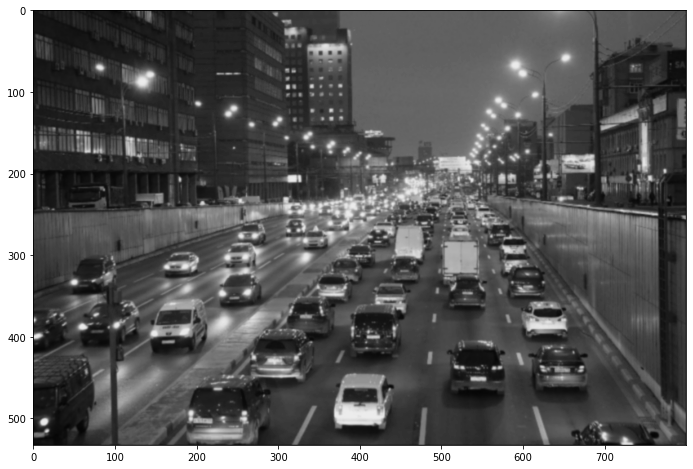

In [9]:
plt.figure(figsize=(12, 8))
plt.imshow(image3, cmap='gray', vmin = 0, vmax = 255)

**5) Считаем градиент**

In [10]:
def get_grad(image):
    image2 = np.empty([image.shape[0], image.shape[1]])
    Gy = np.empty([image.shape[0], image.shape[1]])
    Gx = np.empty([image.shape[0], image.shape[1]])
    teta = np.empty([image.shape[0], image.shape[1]])
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            Gy[i, j] = image[i+1, j-1] + 2*image[i+1, j] + image[i+1, j-1] - image[i-1, j-1] - 2*image[i-1, j] - image[i-1, j+1]
            Gx[i, j] = image[i-1, j+1] + 2*image[i, j+1] + image[i+1, j+1] - image[i-1, j-1] - 2*image[i, j-1] - image[i+1, j-1]
            image2[i, j] = math.sqrt(Gy[i, j] ** 2 + Gx[i, j] ** 2)
            teta[i, j] = round(math.atan2(Gy[i, j], Gx[i, j]) / math.pi * 4) * math.pi / 4
    return image2, teta

In [11]:
image4, teta = get_grad(image3)

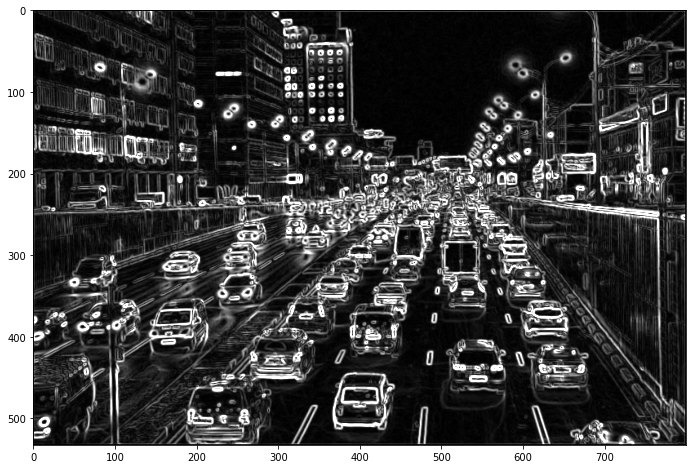

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(image4, cmap='gray', vmin = 0, vmax = 255)

**6) Подавление не максимумов**

In [13]:
def separation_of_max(image, teta):
    image2 = image.copy()
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if np.abs(teta[i,j] + math.pi) < 0.0001 or np.abs(teta[i,j] - math.pi) < 0.0001 or np.abs(teta[i,j]) < 0.0001:
                if image[i,j] < image[i,j-1] or image[i,j] < image[i,j+1]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] + math.pi / 2) < 0.0001 or np.abs(teta[i,j] - math.pi / 2) < 0.0001:
                if image[i,j] < image[i-1,j] or image[i,j] < image[i+1,j]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] - math.pi / 4) < 0.0001 or np.abs(teta[i,j] + 3 * math.pi / 4) < 0.0001:
                if image[i,j] < image[i-1,j+1] or image[i,j] < image[i+1,j-1]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] + math.pi / 4) < 0.0001 or np.abs(teta[i,j] - 3 * math.pi / 4) < 0.0001:
                if image[i,j] < image[i-1,j-1] or image[i,j] < image[i-1,j-1]:
                    image2[i,j] = 0
    return image2

In [14]:
image5 = separation_of_max(image4, teta)

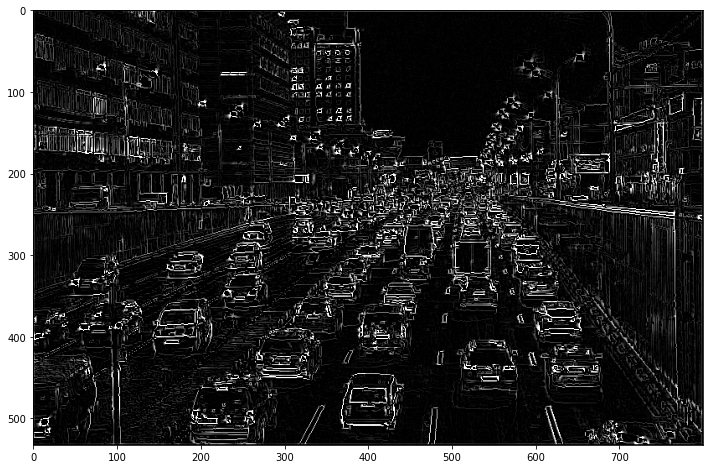

In [15]:
plt.figure(figsize=(12, 8))
plt.imshow(image5, cmap='gray', vmin = 0, vmax = 255, aspect='auto')

**7) Двойная пороговая фильтрация**

In [16]:
def filtration(image, up, down):
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i,j] > up:
                image[i,j] = 255
            elif image[i,j] < down:
                image[i,j] = 0
            else:
                image[i,j] = 127
    return image

In [17]:
image6 = filtration(image5, 90, 60)

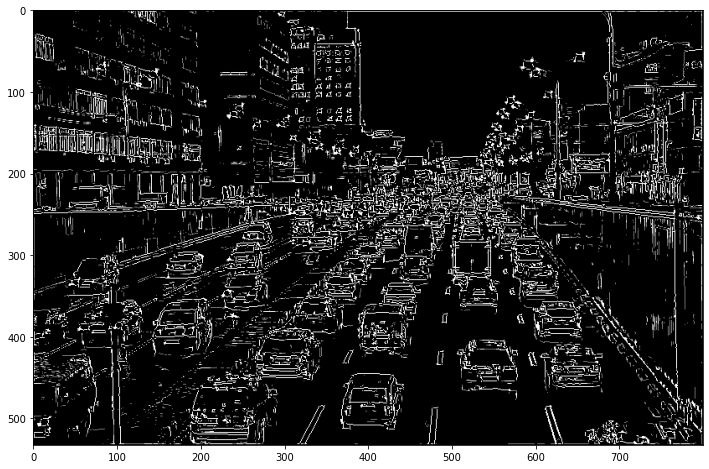

In [18]:
plt.figure(figsize=(12, 8))
plt.imshow(image6, cmap='gray', vmin = 0, vmax = 255, aspect='auto')

**8) Трассировка области неоднозначности**

In [19]:
image7 = image6.copy()

def tracing(x, y):
    if image7[x-1, y] == 127:
        image7[x-1, y] = 255
        tracing(x-1, y)
    if image7[x-1, y-1] == 127:
        image7[x-1, y-1] = 255
        tracing(x-1, y-1)
    if image7[x-1, y+1] == 127:
        image7[x-1, y+1] = 255
        tracing(x-1, y+1)
    if image7[x+1, y] == 127:
        image7[x+1, y] = 255
        tracing(x+1, y)
    if image7[x+1, y-1] == 127:
        image7[x+1, y-1] = 255
        tracing(x+1, y-1)
    if image7[x+1, y+1] == 127:
        image7[x+1, y+1] = 255
        tracing(x+1, y+1)
    if image7[x, y+1] == 127:
        image7[x, y+1] = 255
        tracing(x, y+1)
    if image7[x, y-1] == 127:
        image7[x, y-1] = 255
        tracing(x, y-1)
    

for i in range(1, image7.shape[0] - 1):
    for j in range(1, image7.shape[1] - 1):
        if image7[i, j] == 255:
            tracing(i, j)
            
for i in range(1, image7.shape[0] - 1):
    for j in range(1, image7.shape[1] - 1):
        if image7[i, j] == 127:
            image7[i, j] = 0

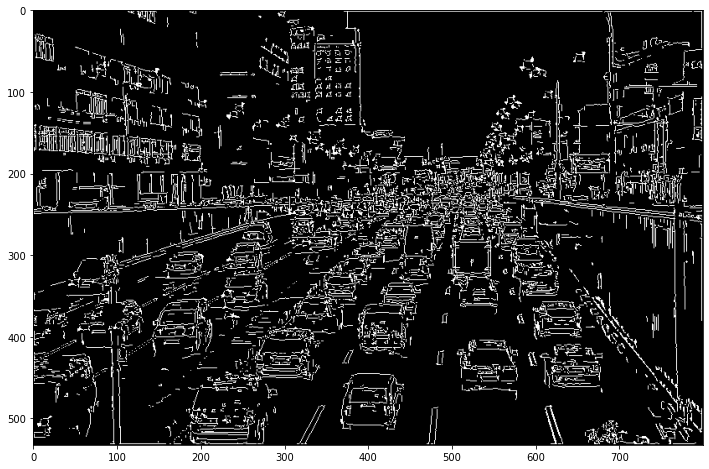

In [20]:
plt.figure(figsize=(12, 8))
plt.imshow(image7, cmap='gray', vmin = 0, vmax = 255, aspect='auto')

**9) OpenCV реализация:**

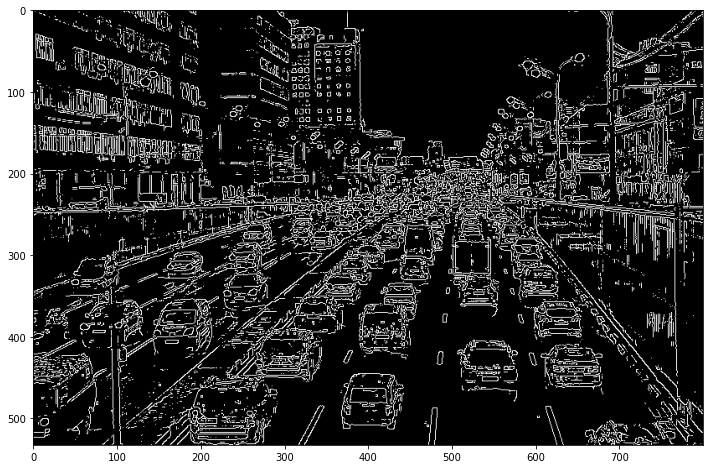

In [21]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.Canny(image, 130, 130), cmap='gray', vmin = 0, vmax = 255, aspect='auto')

### 2. Подсчёт карты расстояний

**1) Используем изображение, полученное при использовании фильтра Канни**

In [22]:
image = image7

**2) Определим карту расстояний**

In [23]:
width = image.shape[0]
height = image.shape[1]
map = [[0] * height for i in range(width)]
map_cv = [[0] * height for i in range(width)]

**3) Функция высчисления карты расстояний**

In [24]:
def distance_map(image):
    width = image.shape[0]
    height = image.shape[1]
    map = [[0] * height for i in range(width)]
    for point_y in range(0, image.shape[0]):
        for point_x in range(0, image.shape[1]):
            distance = round(math.sqrt(width * height))
            step = 1
            flag = False
            while step != width and step != height:
                if image[point_y][point_x] == 0.0:
                    distance = 0
                    break
                if point_x - step > 0:
                    if image[point_y][point_x - step] == 0.0 and step < distance:
                        distance = step
                        flag = True
                if point_x + step < height:
                    if image[point_y][point_x + step] == 0.0 and step < distance:
                        distance = step
                        flag = True
                if point_y - step > 0:
                    if image[point_y - step][point_x] == 0.0 and step < distance:
                        distance = step
                        flag = True
                if point_y + step < width:
                    if image[point_y + step][point_x] == 0.0 and step < distance:
                        distance = step
                        flag = True
                for s in range(1, step + 1):
                    if point_x - step > 0 and point_y - s > 0:
                        if image[point_y - s][point_x - step] == 0.0 and round(math.sqrt(s*s + step*step)) < distance:
                            distance = round(math.sqrt(s*s + step*step))
                            flag = True
                    if point_x - step > 0 and point_y + s < width:
                        if image[point_y + s][point_x - step] == 0.0 and round(math.sqrt(s*s + step*step)) < distance:
                            distance = round(math.sqrt(s*s + step*step))
                            flag = True
                    if point_x + s < height and point_y - step > 0:
                        if image[point_y - step][point_x + s] == 0.0 and round(math.sqrt(step*step + s*s)) < distance:
                            distance = round(math.sqrt(step*step + s*s))
                            flag = True
                    if point_x + s < height and point_y + step < width:
                        if image[point_y + step][point_x + s] == 0.0 and round(math.sqrt(step*step + s*s)) < distance:
                            distance = round(math.sqrt(step*step + s*s))
                            flag = True
                if flag:
                    break
                step += 1
            map[point_y][point_x] = distance
    return map

**4) Собственная реализация**

In [25]:
map = distance_map(image)

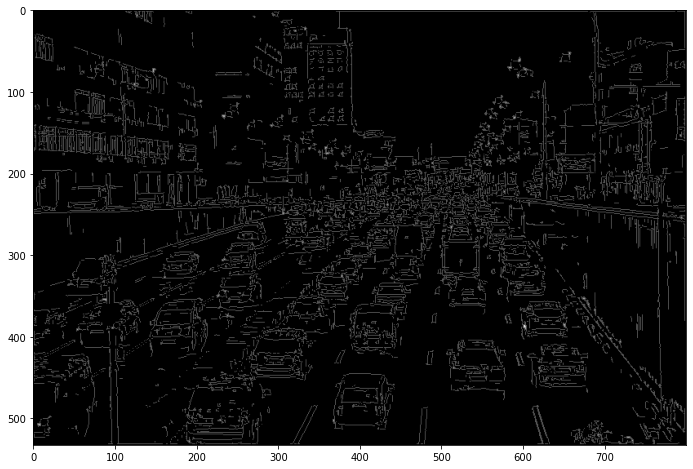

In [26]:
plt.figure(figsize=(12, 8))
plt.imshow(map, cmap='gray')

**5) CV реализация**

In [27]:
map_cv = cv2.distanceTransform(image.astype(np.uint8), cv2.DIST_L2, 5)

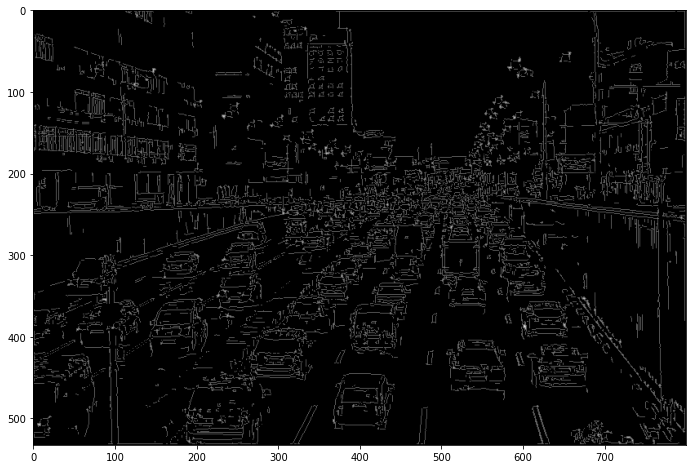

In [28]:
plt.figure(figsize=(12, 8))
plt.imshow(map_cv, cmap='gray')

### 3. Сегментация методом водораздела

### Собственная реализация

Функция возращает индексы соседей пикселя

In [29]:
def get_neighbours(image, i, j):
    result = []
    height, width = image.shape
    if (i > 0 and j > 0):
        result.append((i - 1, j - 1))
    if (i > 0):
        result.append((i - 1, j))
    if (j > 0):
        result.append((i, j - 1))
    if (i + 1 < height and j + 1 < width):
        result.append((i + 1, j + 1))
    if (i + 1 < height):
        result.append((i + 1, j))
    if (j + 1 < width):
        result.append((i, j + 1))
    if (i > 0 and j + 1 < width):
        result.append((i - 1, j + 1))
    if (i + 1 < height and j > 0):
        result.append((i + 1, j - 1))
    return result

Сегментация водоразделом

In [30]:
def Watershed(image):
    INIT = -1
    MASK = -2
    WSHED = 0
    FICTITIOUS = (-1, -1)
    
    current_label = 0
    current_distance = 0
    fifo = deque()
    
    height, width = image.shape
    labels = np.full((height, width), INIT, np.int32)
    distances = np.full((height, width), 0, np.int32)
    neighbours = []
    for i in range(height):
        neighbours.append([])
        for j in range(width):
            neighbours[i].append(get_neighbours(image, i, j))
    
    h_min = np.amin(image).astype(np.int64)
    h_max = np.amax(image).astype(np.int64)
    for h in range(h_min, h_max):
        for i in range (height):
            for j in range (width):
                if (image[i, j] == h):
                    labels[i, j] = MASK
                    if ((i > 0 and j > 0 and labels[i - 1][j - 1] >= 0) or
                        (i > 0 and labels[i - 1][j] >= 0) or
                        (j > 0 and labels[i][j - 1] >= 0) or
                        (i + 1 < len(labels) and j + 1 < len(labels[0]) and labels[i + 1][j + 1] >= 0) or
                        (i + 1 < len(labels) and labels[i + 1][j] >= 0) or
                        (j + 1 < len(labels[0]) and labels[i][j + 1] >= 0) or
                        (i > 0 and j + 1 < len(labels[0]) and labels[i - 1][j + 1] >= 0) or
                        (i + 1 < len(labels) and j > 0 and labels[i + 1][j - 1] >= 0)):
                            distances[i, j] = 1
                            fifo.append((i, j))
        current_distance = 1
        fifo.append(FICTITIOUS)
        while fifo:
            p = fifo.popleft()
            if (p == FICTITIOUS):
                if fifo:
                    break
                else:
                    fifo.append(FICTITIOUS)
                    current_distance += 1
                    p = fifo.popleft()
            for nb in neighbours[p[0]][p[1]]:
                if distances[nb[0]][nb[1]] < current_distance and labels[nb[0]][nb[1]] >= 0:
                    if labels[nb[0]][nb[1]] > 0: 
                        if labels[p[0]][p[1]] == MASK or labels[p[0]][p[1]] == WSHED:
                            labels[p[0]][p[1]] = labels[nb[0]][nb[1]]
                        elif labels[p[0]][p[1]] != labels[nb[0]][nb[1]]:
                            labels[p[0]][p[1]] = WSHED
                    elif labels[p[0]][p[1]] == MASK:
                        labels[p[0]][p[1]] = WSHED
                elif labels[nb[0]][nb[1]] == MASK and distances[nb[0]][nb[1]] == 0:
                    distances[nb[0]][nb[1]] = current_distance + 1
                    fifo.append(nb)
        for i in range (height):
            for j in range (width):
                if (image[i, j] == h):
                    distances[i, j] = 0
                    if (labels[i, j] == MASK):
                        current_label += 1
                        fifo.append((i, j))
                        labels[i, j] = current_label
                        while fifo:
                            q = fifo.popleft()
                            for nb in neighbours[q[0]][q[1]]:
                                if (labels[nb[0]][nb[1]] == MASK):
                                    fifo.append(nb)
                                    labels[nb[0]][nb[1]] = current_label
    return labels

Бинаризация изображения (черно-белое на выходе)

In [31]:
def my_treshold(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i, j] > 127):
                image[i, j] = 255
            else:
                image[i, j] = 0
    return image

Считываем изображение, переводим его в оттенки серого, затем в черно-белое, запускаем сегментацию водоразделом, выводим результат

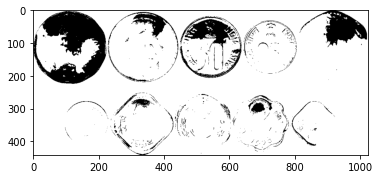

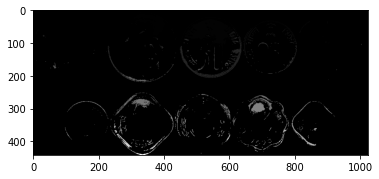

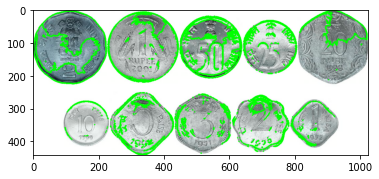

In [32]:
image = cv2.imread("coins1.jpg")
gray = to_gray(cv2.pyrMeanShiftFiltering(image, 21, 51))
image_to_change = my_treshold(gray)
#image_to_change = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(image_to_change, cmap='gray')
plt.show()
labels = Watershed(image_to_change)
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #c = max(cnts, key=cv2.contourArea)
    #((x, y), r) = cv2.minEnclosingCircle(c)
    #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.drawContours(image, cnts, 0, (0,255,0), 3)
plt.imshow(labels, cmap='gray')
plt.show()
plt.imshow(image, cmap='gray')
plt.show()

## Cv реализация

<ipython-input-33-0309da7226b4>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)


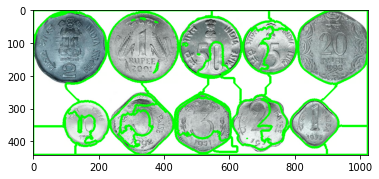

In [33]:
image = cv2.imread("coins1.jpg")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = cv2.watershed(image, markers)
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    #c = max(cnts, key=cv2.contourArea)
    #((x, y), r) = cv2.minEnclosingCircle(c)
    #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.drawContours(image, cnts, 0, (0,255,0), 3)
plt.imshow(image, cmap='gray')
plt.show()

Выделение сегментов показано с помощью отрисовки их границ. Можно заметить, что cv реализация отрабатывает немного получше, но собственная реализация тем не менее выделяет большую часть монет